#### imports 

In [2]:
%pylab inline 
%config InlineBackend.figure_format='retina'
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.95' # use for higher gpu memory capacity
import jax
import jax.numpy as np
import numpy
import vbjax as vb
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
# other packages
import scipy.signal as ss
from tqdm import tqdm
from joblib import Parallel, delayed
# internal functions
from pathlib import Path

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
c[vbjax] ███▒▒▒▒▒▒▒ loading
c[vbjax] (ﾉ☉ヮ⚆)ﾉ ⌒*:･ﾟ✧ can haz 16 cores
c[vbjax] ò_ô shtns is not available
c[vbjax] ᕕ(ᐛ)ᕗ ready
gpu


In [3]:
cwd = os.getcwd()
cwd

'/home/anastasios/Marseille/projects/neuromodulation/vbjax/examples'

In [4]:
i = 0; head_tail = '';
while head_tail != 'vbjax':
    head = Path(cwd).parents[i]
    head_tail = os.path.split(head)[1]
    i += 1
sys.path.append(os.path.join(head, 'mymodules'))
import nm, simulate, metrics, plotting, phaseplane

### simulate

this is a simple simulation of the model

In [5]:
T = 4000  # total time of simulation in ms
dt = 1e-2 # step in ms
y0 = np.array([0.1, -70, 0, 0, 0, 0, 0])  # initial conditions for the 6 state variables
cy = np.zeros(3, dtype=np.float32)  # array for c_inh, c_exh, c_dopa
params = nm.dopa_default_params     # default params
params

DopaParams(a=0.04, b=5.0, c=140.0, alpha=0.013, beta=0.4, uj=12, Bd=0.2, ga=12.0, ea=0.0, gg=12.0, eg=-80.0, Iext=0.0, Sja=0.8, Sjg=1.2, tauSa=2.6, tauSg=2.6, k=100000.0, Km=150.0, Vmax=1300.0, tauDe=500.0, tauM=500.0, Rd=1.0, Sp=-1.0, Eta=12.0, Delta=5.0, wi=0.0001, we=0.0001, wd=0.0001, sigma=0.001)

In [6]:
# replacement of params without sweeping!
params = params._replace(a=0.025, uj=5, beta=0.4, b=1)

In [7]:
ys = simulate.simulate(y0, cy, params, dopa_dfun=nm.dopaMF_explicit_dfun, T=T, dt=dt)
xs = np.arange(T, step=dt)
print(ys.shape, xs.shape)

(400000, 7) (400000,)


In [8]:
R, V, U, Sa, Sg, Dp, M = ys.T  
sv_names = ('$r$', '$V$', '$u$', '$Sa$', '$Sg$', '$Dp$', '$Md$')

### plot timeseries

#### find transient

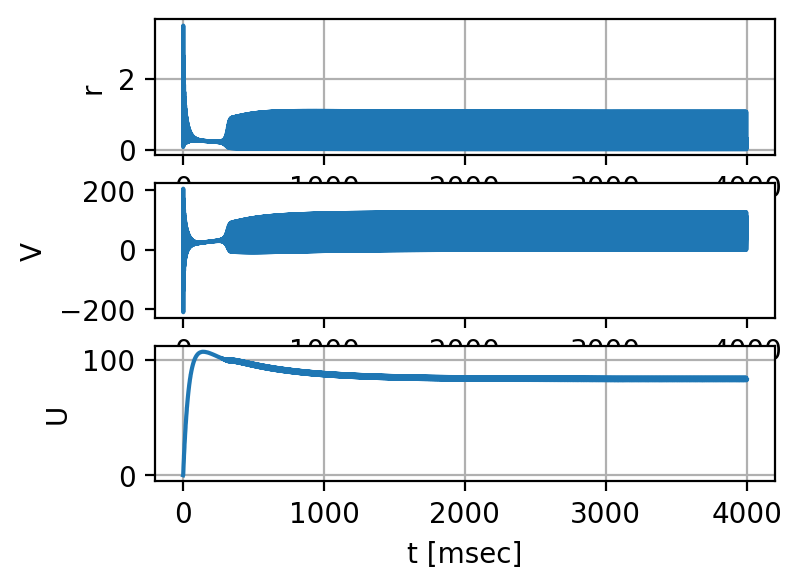

In [9]:
figure(figsize=(4,3))
subplot(311)
plot(xs, R)
ylabel('r')
grid()
subplot(312)
plot(xs, V)
ylabel('V')
subplot(313)
plot(xs, U)
ylabel('U')
xlabel('t [msec]')
grid()

<Figure size 300x300 with 0 Axes>

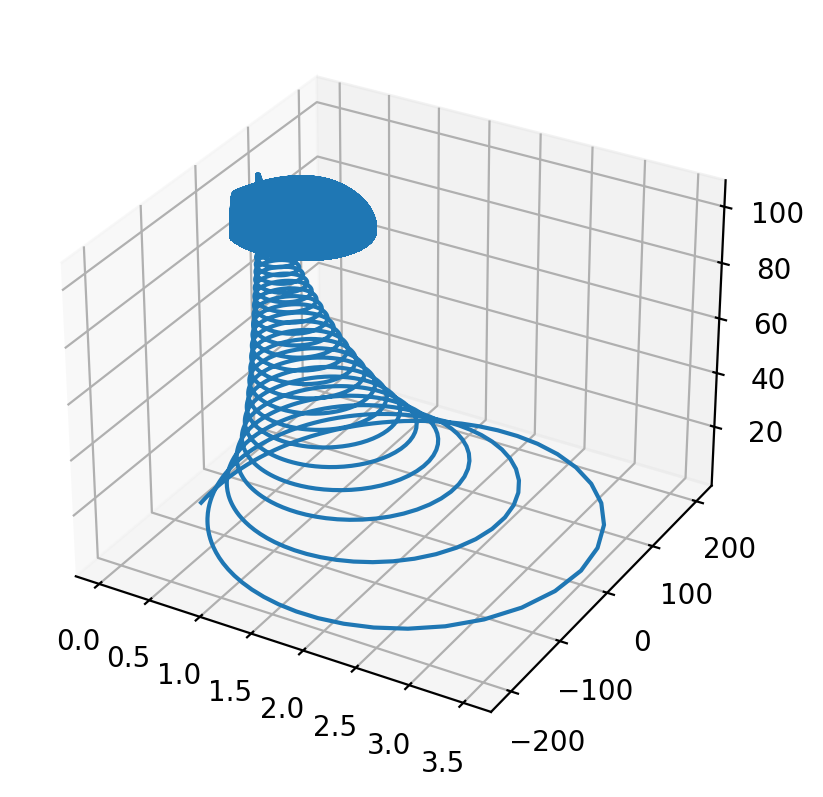

In [10]:
figure(figsize=(3,3))
f, ax = plt.subplots(1,1, subplot_kw={'projection':'3d'})
ax.plot(R, V, U);

#### focusing on specific intervals

Text(0.5, 0, 't [ms]')

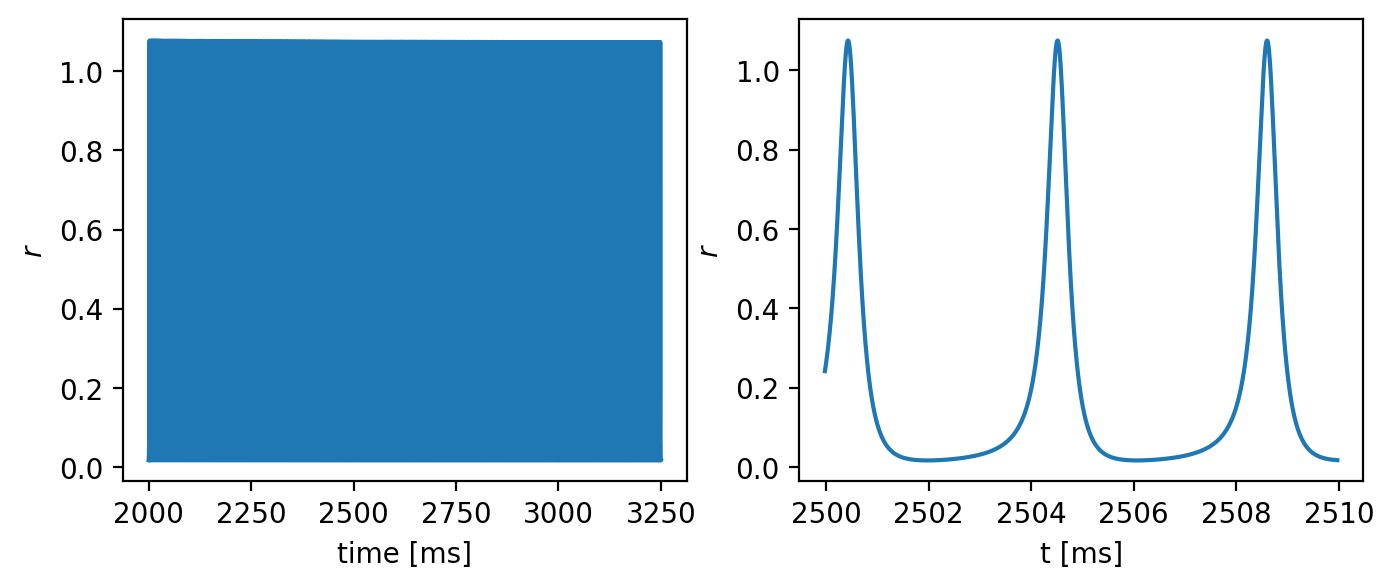

In [11]:
# get starting point (sp) and final point (fp) 
# using the function plotting.get_if()
# where you input the timestamps that you want in [ms]
sp, fp = plotting.get_if(xs, 2000, 3250) 
figure(figsize=(8,3))
subplot(121)
plot(xs[sp:fp], R[sp:fp])
xlabel('time [ms]')
ylabel('$r$')
subplot(122)
sp, fp = plotting.get_if(xs, 2500, 2510)
plot(xs[sp:fp], R[sp:fp])
ylabel('$r$')
xlabel('t [ms]')

### Power Spectrum analysis

In [12]:
fs = metrics.get_fs(dt)                  # 1. get the frequency in Hz
r = R[sp:].copy()                        # 2. restrict more r optionally
freq, Sxx = metrics.get_ps(1/fs, r)      # 3. get power spectrum
freq.shape, Sxx.shape

((75001,), (75001,))

#### plot power spectrum

Text(0, 0.5, 'PS')

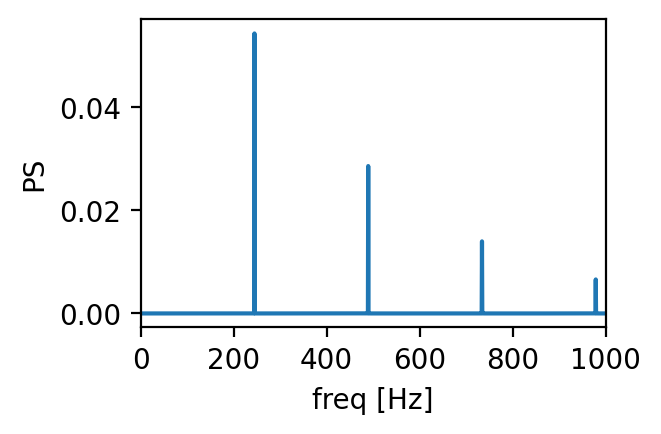

In [13]:
figure(figsize=(3,2))
plot(freq, Sxx.T)
xlim(0,1000)
xlabel('freq [Hz]')
ylabel('PS')

### sweep across `params`

In [14]:
params = nm.dopa_default_params
alpha = np.geomspace(start = 1e-2, stop = 5e-2, num = 8)
sweep_params = params._replace(alpha=alpha)
sweep_params

DopaParams(a=0.04, b=5.0, c=140.0, alpha=Array([0.01      , 0.01258499, 0.0158382 , 0.01993236, 0.02508485,
       0.03156926, 0.03972988, 0.05000001], dtype=float32), beta=0.4, uj=12, Bd=0.2, ga=12.0, ea=0.0, gg=12.0, eg=-80.0, Iext=0.0, Sja=0.8, Sjg=1.2, tauSa=2.6, tauSg=2.6, k=100000.0, Km=150.0, Vmax=1300.0, tauDe=500.0, tauM=500.0, Rd=1.0, Sp=-1.0, Eta=12.0, Delta=5.0, wi=0.0001, we=0.0001, wd=0.0001, sigma=0.001)

In [15]:
_, ys = simulate.sweep_node(y0, cy, sweep_params, nm.dopaMF_explicit_dfun, T=T, dt=dt, sigma=0)
xs = np.arange(T, step=dt)

In [16]:
ys.shape

(8, 400000, 7)

In [17]:
R, V, U, Sa, Sg, Dp, M = ys.transpose(-1,0,1)

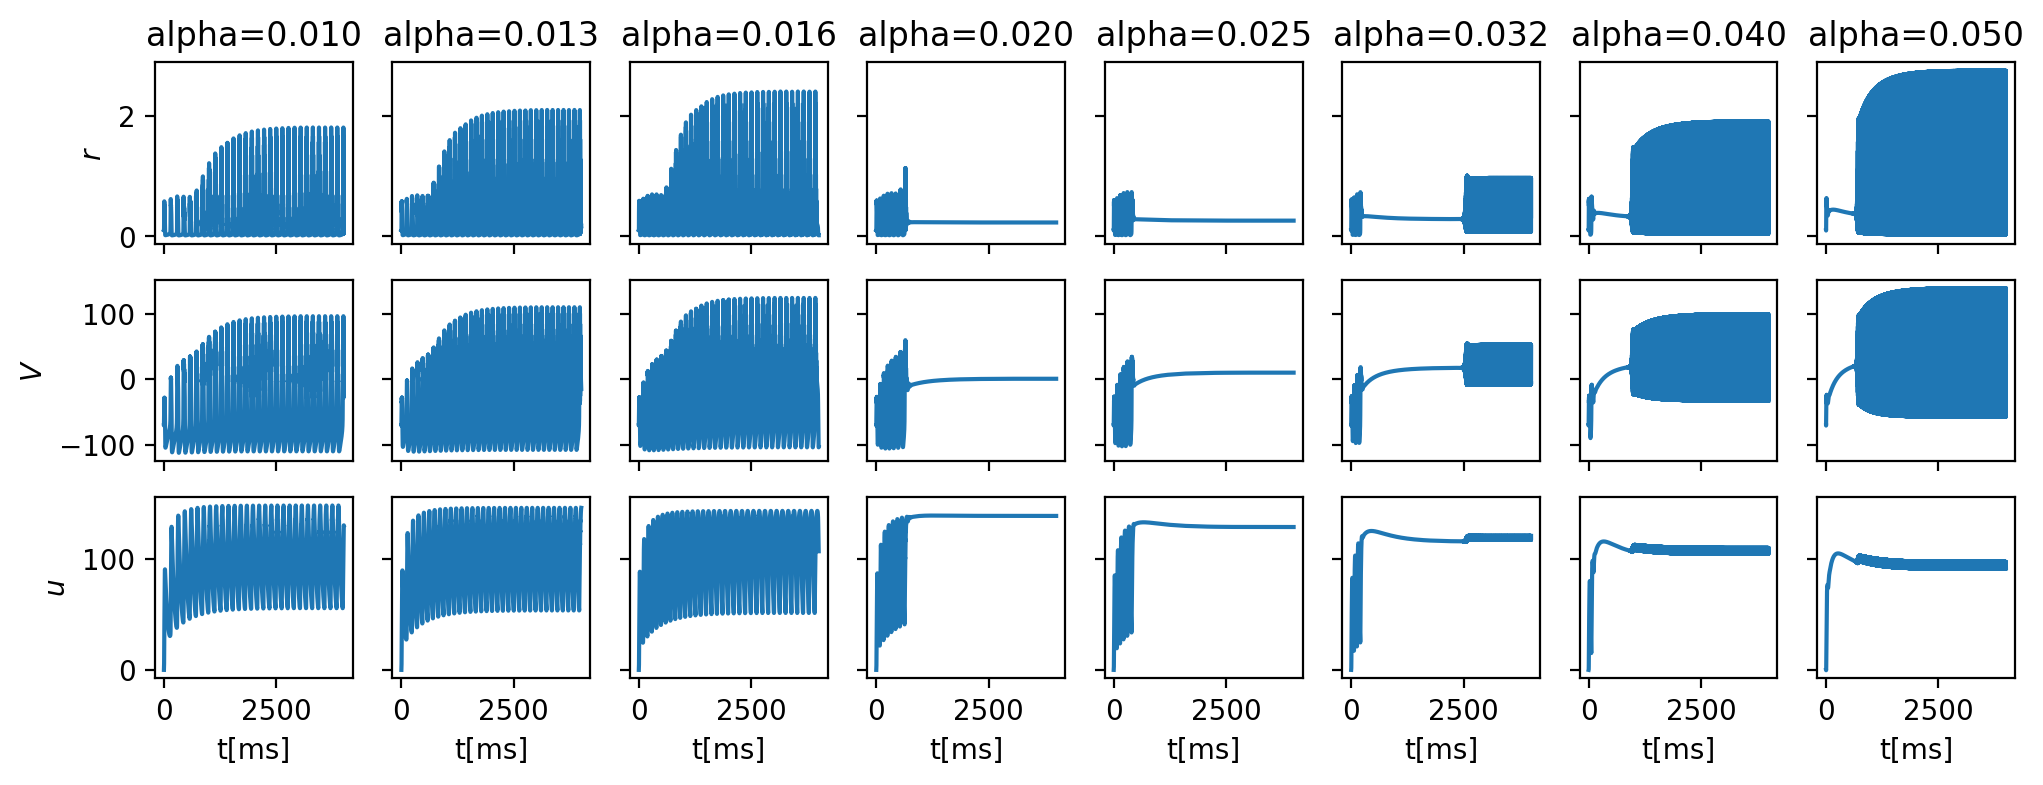

In [18]:
f, ax = plt.subplots(3,8,sharex='col', sharey='row',
                    figsize=(12,4))
for j in range(ys.shape[0]):
    ax[0,j].plot(xs, R[j])
    ax[1,j].plot(xs, V[j])
    ax[2,j].plot(xs, U[j])
    ax[2,j].set_xlabel('t[ms]')
    ax[0,j].set_title(f'alpha={sweep_params.alpha[j]:.3f}')
for i in range(3): ax[i,0].set_ylabel(sv_names[i])

#### check individual cases

Text(0.5, 1.0, 'alpha=0.013')

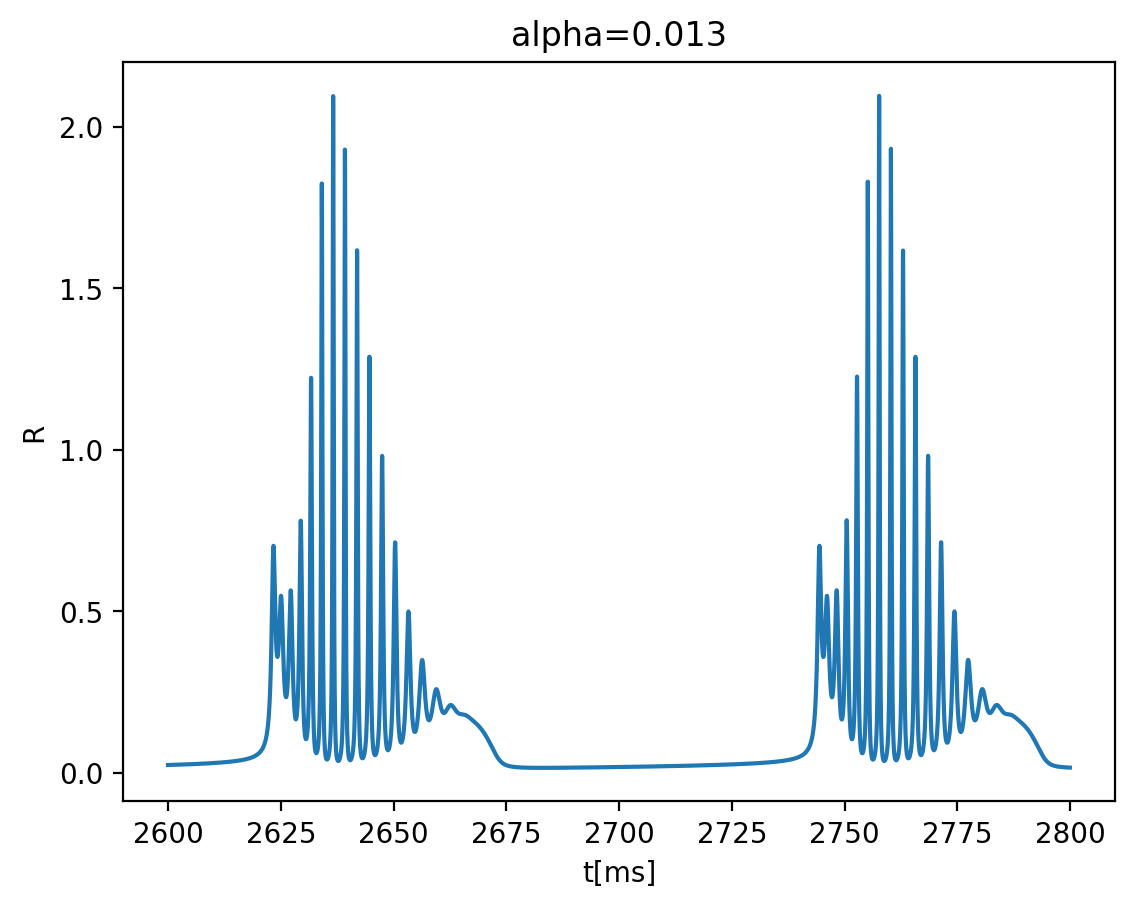

In [19]:
sp, fp = plotting.get_if(xs, 2600, 2800)
plot(xs[sp:fp], R[1,sp:fp]) # for index=1 -> alpha = 0.013
xlabel('t[ms]')
ylabel('R')
title(f'alpha={sweep_params.alpha[1]:.3f}')

## phase plane

In [58]:
# timepoints of different regimes 
bursting_timepoint = 2765; resting_timepoint = 2700 # [msec]
bursting_timepoint = plotting.get_if(xs, bursting_timepoint)
resting_timepoint = plotting.get_if(xs, resting_timepoint)
y_rest = ys[1, resting_timepoint,:] # for index=1 -> alpha = 0.013
y_burst = ys[1, bursting_timepoint,:]

([<matplotlib.lines.Line2D at 0x7ab94586c730>,
 ['$r$-nullcline', '$V$-nullcline'])

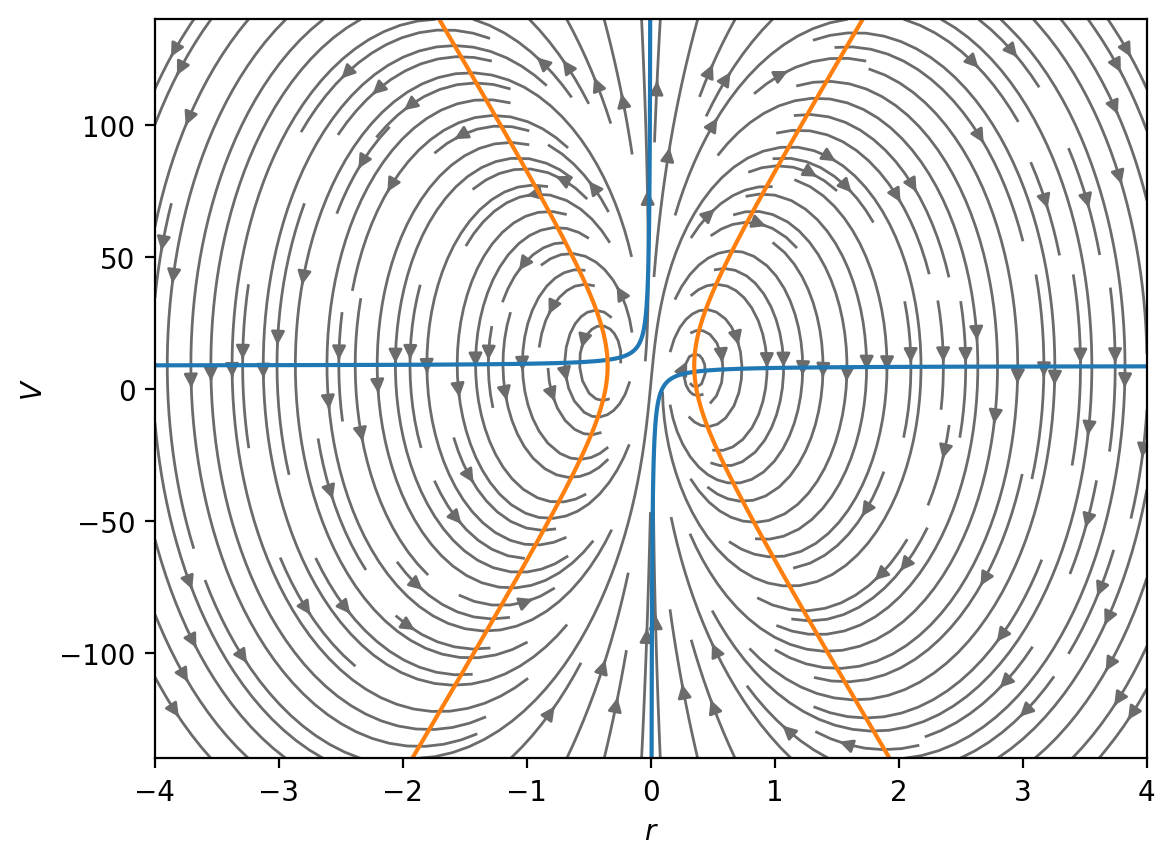

In [59]:
params = params._replace(alpha = sweep_params.alpha[1])
# setting the rV ranges
r_min = -4; r_max = 4; V_min = -140; V_max = 140; n_samples = 1024
pp = phaseplane.PhasePlane(r_min, r_max, V_min, V_max, n_samples)
# fit with the proper function
pp.fit(y_burst, cy, params, nm.dopaMF_explicit_dfun) # looks like it works the same with the dopaMF_dfun
ys_burst = pp.get_grid_ys()
# plot the flow & nullclines
# r_nc, V_nc = pp.get_rV_nullclines()
pp.plot_phaseplane(nullclines='contours')

#### simulate the fast subsystem at the bursting regime and plot the trajectory over the phase plane

In [64]:
r, V, u, Sa, Sg, De, M = y_burst
y0_rV = np.array([r,V])
sv = nm.dopa_default_initial_state
sv = sv._replace(u=u, Sa=Sa, Sg=Sg, De=De, M=M)
# params = params._replace(a=0.02)

In [65]:
y_rV = simulate.simulate(y0_rV, cy, (sv, params), nm.dopaMF_explicit_fast_dfun, T=5e2, dt=1e-2)
t = np.arange(T, step=dt)

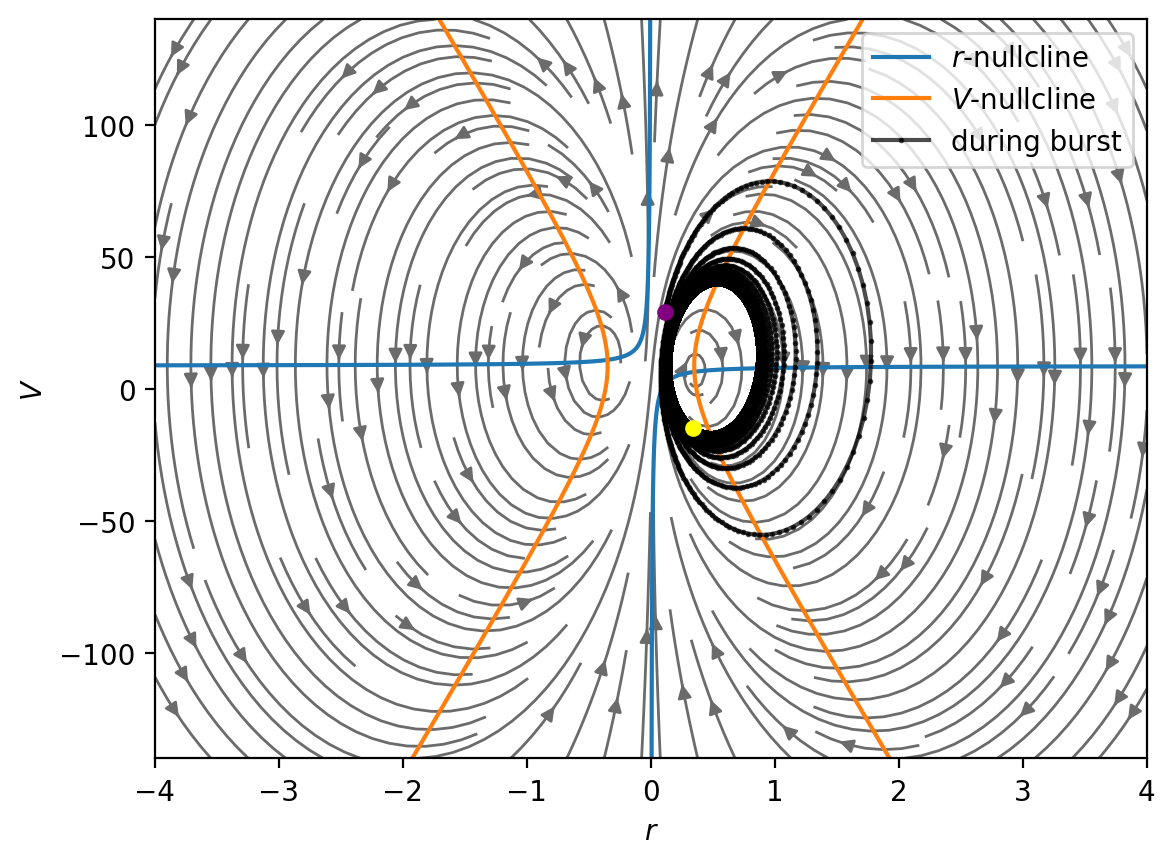

In [66]:
# plot the flow & nullclines
r_nc, V_nc = pp.get_rV_nullclines()
handles, labels = pp.plot_phaseplane(nullclines='contours')
line4, = plot(y_rV[:,0], y_rV[:,1], '-o', color='k', ms=1, alpha=0.7, label='during burst')
plot(y_rV[0,0], y_rV[0,1], '-o', color='purple', ms=5)
plot(y_rV[-1,0], y_rV[-1,1], '-o', color='yellow', ms=5)
handles.extend([line4])
labels.extend(['during burst'])
# Create the combined legend
legend(handles, labels, loc='upper right')
# xlim(-1,2); ylim(-10,50)